<!--BOOK_INFORMATION-->
<img align="left" style="width:80px;height:98px;padding-right:20px;" src="https://raw.githubusercontent.com/joe-papa/pytorch-book/main/files/pytorch-book-cover.jpg">

This notebook contains an excerpt from the [PyTorch Pocket Reference](http://pytorchbook.com) book by [Joe Papa](http://joepapa.ai); content is available [on GitHub](https://github.com/joe-papa/pytorch-book).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joe-papa/pytorch-book/blob/main/04_03_Generative_Learning_FMNIST.ipynb)

# Chapter 4 - Neural Network Development Reference Designs
# Generative Learning - Generating Fashion MNIST with DCGAN

## Data Processing

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

CODING_SIZE = 100
BATCH_SIZE = 32
IMAGE_SIZE = 64

device = torch.device("cuda:0" if
  torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

dataset = datasets.FashionMNIST(
                './', 
                train=True, 
                download=True, 
                transform=transform)

dataloader = DataLoader(
                dataset, 
                batch_size=BATCH_SIZE, 
                shuffle=True, 
                num_workers=8)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


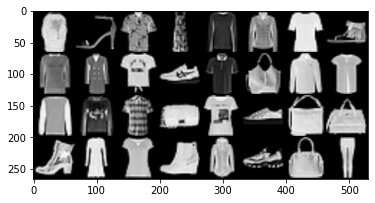

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

data_batch, labels_batch = next(iter(dataloader))
grid_img = make_grid(data_batch, nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

## Model Design

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, coding_sz):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(coding_sz, 
                               1024, 4, 1, 0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 
                               512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 
                               256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 
                               128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 
                               1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.net(input)

netG = Generator(CODING_SIZE).to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, 
              self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)

netD = Discriminator().to(device)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [ ]:
from torch import optim

criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), 
                        lr=0.0002, 
                        betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), 
                        lr=0.0001, 
                        betas=(0.5, 0.999))

In [ ]:
real_labels = torch.full((BATCH_SIZE,), 
                       1., 
                       dtype=torch.float, 
                       device=device)

fake_labels = torch.full((BATCH_SIZE,), 
                       0., 
                       dtype=torch.float, 
                       device=device)

In [ ]:
G_losses = []
D_losses = []
D_real = []
D_fake = []

z = torch.randn((BATCH_SIZE, 100)).view(-1, 100, 1, 1).to(device)
test_out_images = []

In [ ]:
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
  print(f'Epoch: {epoch}')
  for i, batch in enumerate(dataloader):
    if (i%200==0):
      print(f'batch: {i} of {len(dataloader)}')
    
    # Train Descriminator with all-real batch
    netD.zero_grad()
    real_images = batch[0].to(device) *2. - 1.
    output = netD(real_images).view(-1) # <1>
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()

    # Train Descriminator with all-fake batch
    noise = torch.randn((BATCH_SIZE, 
                         CODING_SIZE))
    noise = noise.view(-1,100,1,1).to(device)
    fake_images = netG(noise)
    output = netD(fake_images).view(-1) # <2>
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    errD.backward(retain_graph=True) # <3>
    optimizerD.step()

    # Train Generator to generate better fakes
    netG.zero_grad()
    output = netD(fake_images).view(-1) # <4>
    errG = criterion(output, real_labels)
    errG.backward() # <5>
    D_G_z2 = output.mean().item()
    optimizerG.step()

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    D_real.append(D_x)
    D_fake.append(D_G_z2)

  test_images = netG(z).to('cpu').detach() # <6>
  test_out_images.append(test_images)  

Epoch: 0
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 1
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 2
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 3
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 4
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 180

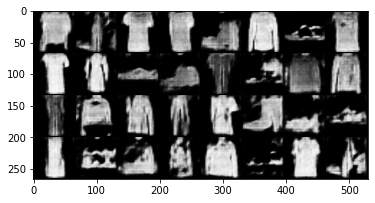

In [ ]:
grid_img = make_grid((test_out_images[0]+1.)/2., # <1>
                     nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

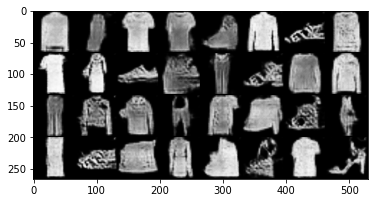

In [ ]:
grid_img = make_grid((test_out_images[4]+1.)/2., # <2>
                     nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

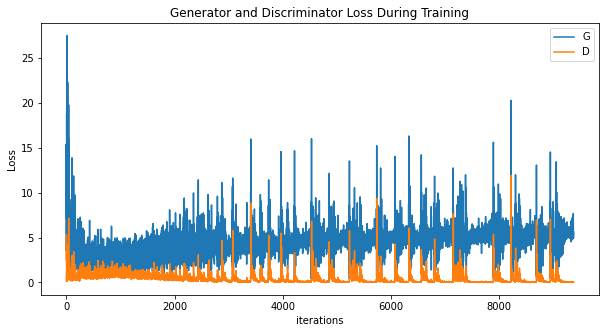

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

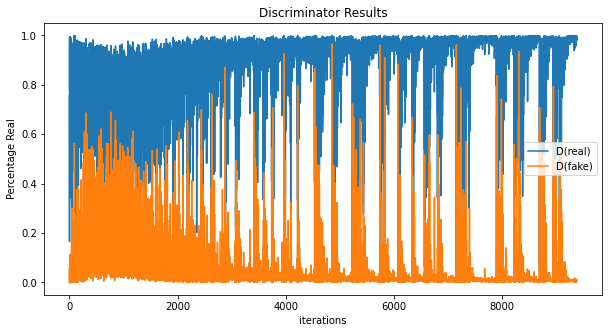

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Results")
plt.plot(D_real,label="D(real)")
plt.plot(D_fake,label="D(fake)")
plt.xlabel("iterations")
plt.ylabel("Percentage Real")
plt.legend()
plt.show()

In [ ]:
torch.save(netG.state_dict(), './gan.pt')